Analyzing parquet file: data/network_all_months_plus_25833_length_with_fahrradstrasse_noClip.parquet
Parquet file has 1 row groups and approximately 592,136 rows
Processing 1 row groups


Processing row groups:   0%|          | 0/1 [00:00<?, ?it/s]

Row group 0: 592,136 rows, processing in 12 chunks


Chunks in row group 0:   0%|          | 0/12 [00:00<?, ?it/s]

Analysis complete. Processed 592,136 segments
Summary table saved to analysis_results/BeschrDatensatz/summary_table.csv


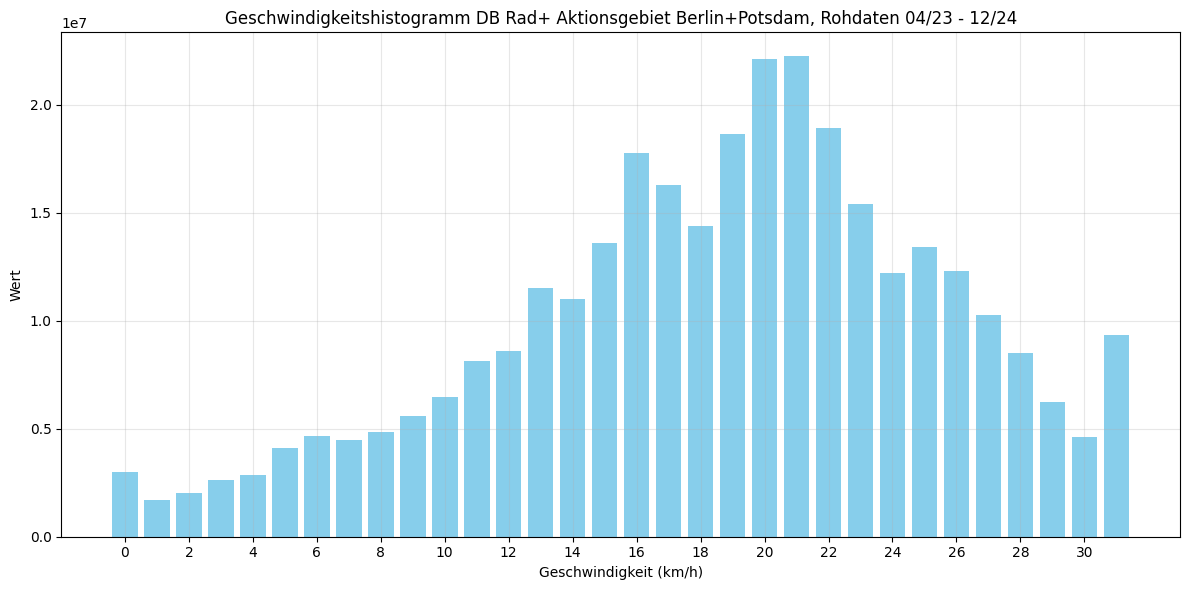

Combined histogram saved to analysis_results/BeschrDatensatz/combined_speed_histogram.png
Raw histogram data saved to analysis_results/BeschrDatensatz/combined_histogram_data.csv

Summary:
Total segments (rows): 592,136
Total route count: 317,762,178.0
Total length: 22684.59 km


In [1]:
# Histogramm der Rohdaten für Untersuchungszeitraum
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pyarrow.parquet as pq
import gc
from tqdm.notebook import tqdm

# Configuration - modify to match your setup
PARQUET_FILE = "data/network_all_months_plus_25833_length_with_fahrradstrasse_noClip.parquet"
OUTPUT_DIR = "analysis_results/BeschrDatensatz"
COLUMN_HIST = '2304-2412_speeds'  # Column for speed histogram data
COLUMN_LENGTH = 'length_m'  # Column for length in meters
COLUMN_ROUTE_COUNT = '2304-2412_route_count'  # Column for route count

# Make sure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def log(message):
    """Print a timestamped log message"""
    print(message)

def force_gc():
    """Force garbage collection"""
    gc.collect()

def parse_histogram(hist_str):
    """Parse histogram string to numpy array"""
    try:
        if isinstance(hist_str, str):
            hist_str = hist_str.strip('[]')
            # Fast NumPy parsing
            try:
                values = np.fromstring(hist_str, sep=',')
                return values
            except:
                # Fallback to manual parsing if NumPy method fails
                values = [float(x) for x in hist_str.split(',')]
                return np.array(values)
        else:
            return np.zeros(32)  # Return zeros for missing histograms
    except Exception as e:
        log(f"Error parsing histogram: {e}")
        return np.zeros(32)

def generate_summary_table():
    """Generate a summary table with segment count, route count, length, and speed histogram"""
    log(f"Analyzing parquet file: {PARQUET_FILE}")
    
    # Verify the parquet file exists
    if not os.path.exists(PARQUET_FILE):
        log(f"Error: File {PARQUET_FILE} not found")
        return None
    
    # Get file info to understand what we're working with
    parquet_file = pq.ParquetFile(PARQUET_FILE)
    num_row_groups = parquet_file.metadata.num_row_groups
    total_rows = parquet_file.metadata.num_rows
    log(f"Parquet file has {num_row_groups} row groups and approximately {total_rows:,} rows")
    
    # Define the specific columns we need
    columns = [COLUMN_HIST, COLUMN_LENGTH, COLUMN_ROUTE_COUNT]
    
    # Initialize counters and accumulators
    segment_count = 0
    total_route_count = 0
    total_length_km = 0
    combined_histogram = np.zeros(32)  # Assuming 32 bins as in the original code
    
    # Define chunk size for efficient processing within each row group
    CHUNK_SIZE = 50000
    
    # Process each row group with efficient chunking
    log(f"Processing {num_row_groups} row groups")
    
    for rg in tqdm(range(num_row_groups), desc="Processing row groups"):
        try:
            # Get the row group size to determine number of chunks needed
            row_group_metadata = parquet_file.metadata.row_group(rg)
            row_group_size = row_group_metadata.num_rows
            num_chunks = (row_group_size + CHUNK_SIZE - 1) // CHUNK_SIZE  # Ceiling division
            
            log(f"Row group {rg}: {row_group_size:,} rows, processing in {num_chunks} chunks")
            
            # Read the entire row group
            table = parquet_file.read_row_group(rg, columns=columns)
            
            # Process each chunk of the row group
            for chunk_idx in tqdm(range(num_chunks), desc=f"Chunks in row group {rg}", leave=False):
                # Calculate offsets
                offset = chunk_idx * CHUNK_SIZE
                length = min(CHUNK_SIZE, row_group_size - offset)
                
                # Extract just this chunk from the row group
                chunk_table = table.slice(offset, length)
                df_chunk = chunk_table.to_pandas()
                
                # Count segments (rows)
                segment_count += len(df_chunk)
                
                # Sum route counts (handling NaN values)
                if COLUMN_ROUTE_COUNT in df_chunk.columns:
                    total_route_count += df_chunk[COLUMN_ROUTE_COUNT].fillna(0).sum()
                
                # Sum lengths (handling NaN values)
                if COLUMN_LENGTH in df_chunk.columns:
                    total_length_km += df_chunk[COLUMN_LENGTH].fillna(0).sum() / 1000  # Convert m to km
                
                # Process histograms
                for _, row in df_chunk.iterrows():
                    if COLUMN_HIST in row and not pd.isna(row[COLUMN_HIST]):
                        hist = parse_histogram(row[COLUMN_HIST])
                        if len(hist) > 0:
                            combined_histogram += hist
                
                # Clean up to free memory after each chunk
                del df_chunk, chunk_table
                force_gc()
            
            # Clean up the entire row group data
            del table
            force_gc()
                
        except Exception as e:
            log(f"Error processing row group {rg}: {e}")
    
    log(f"Analysis complete. Processed {segment_count:,} segments")
    
    # Create summary table
    summary_data = {
        "Metric": ["Segments (rows)", "Total route count", "Total length (km)"],
        "Value": [segment_count, total_route_count, round(total_length_km, 2)]
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save summary table
    summary_df.to_csv(os.path.join(OUTPUT_DIR, 'summary_table.csv'), index=False)
    log(f"Summary table saved to {os.path.join(OUTPUT_DIR, 'summary_table.csv')}")
    
    # Plot and save the combined histogram
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(combined_histogram)), combined_histogram, color='skyblue')
    plt.xticks(range(0, len(combined_histogram), 2))  # Show every second tick
    plt.title('Geschwindigkeitshistogramm DB Rad+ Aktionsgebiet Berlin+Potsdam, Rohdaten 04/23 - 12/24')
    plt.xlabel('Geschwindigkeit (km/h)')
    plt.ylabel('Wert')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.savefig(os.path.join(OUTPUT_DIR, 'combined_speed_histogram.png'), dpi=300, bbox_inches='tight')
    plt.show()
    log(f"Combined histogram saved to {os.path.join(OUTPUT_DIR, 'combined_speed_histogram.png')}")
    
    # Save the raw histogram data
    np.savetxt(os.path.join(OUTPUT_DIR, 'combined_histogram_data.csv'), combined_histogram, delimiter=',')
    log(f"Raw histogram data saved to {os.path.join(OUTPUT_DIR, 'combined_histogram_data.csv')}")
    
    # Print summary
    log("\nSummary:")
    log(f"Total segments (rows): {segment_count:,}")
    log(f"Total route count: {total_route_count:,}")
    log(f"Total length: {total_length_km:.2f} km")
    
    return summary_df, combined_histogram

# Run the analysis
summary_table, histogram = generate_summary_table()